In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.17.0
3.6.0


# Load Data

In [2]:
os.listdir("Original")

['Benign', 'Early', 'Pre', 'Pro']

In [3]:
path_main = "Original"
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    
    print(f'Folder: {folder}\n')
    print(f'Number of elements: {len(list_of_elements)}\n')
    print(f'First item\'s name: {list_of_elements[0]}\n')
    print('***************************')

Folder: Benign

Number of elements: 504

First item's name: WBC-Benign-001.jpg

***************************
Folder: Early

Number of elements: 985

First item's name: WBC-Malignant-Early-001.jpg

***************************
Folder: Pre

Number of elements: 963

First item's name: WBC-Malignant-Pre-001.jpg

***************************
Folder: Pro

Number of elements: 804

First item's name: WBC-Malignant-Pro-001.jpg

***************************


# plot images 

In [4]:
Benign_path = "Original\Benign"
malignant_pre_B_path = "Original\Pre"
malignant_pro_B_path = "Original\Pro"
malignant_early_pre_B_path = "Original\Early"

In [21]:
def plot_imgs(item_dir,num_imgs=15):
    all_item_dirs = os.listdir(item_dir)
    item_files=[os.path.join(item_dir,file) for file in all_item_dirs][:num_imgs]
    
    plt.figure(figsize=(20,10))
    for idx,img_path in enumerate (item_files):
        plt.subplot(5,5,idx+1)
        img=plt.imread(img_path)
        plt.imshow(img)
        
    plt.tight_layout()

# **Benign**

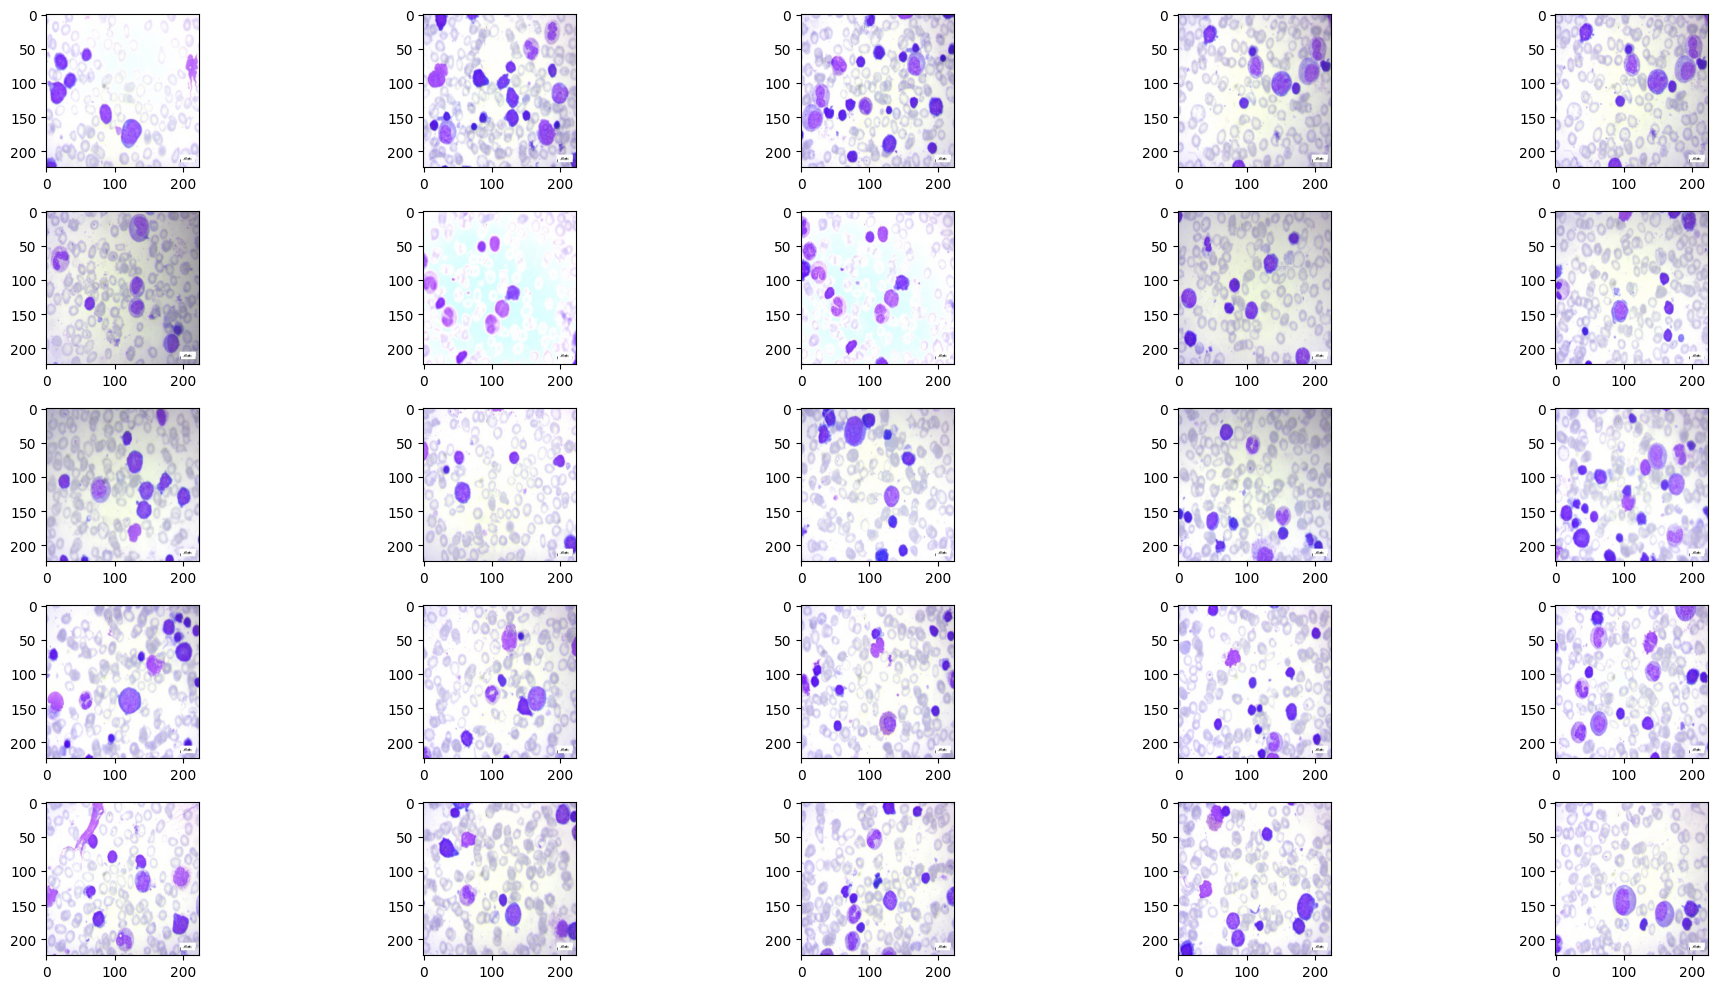

In [22]:
plot_imgs(Benign_path,num_imgs=25)

# **malignant-pre-B**

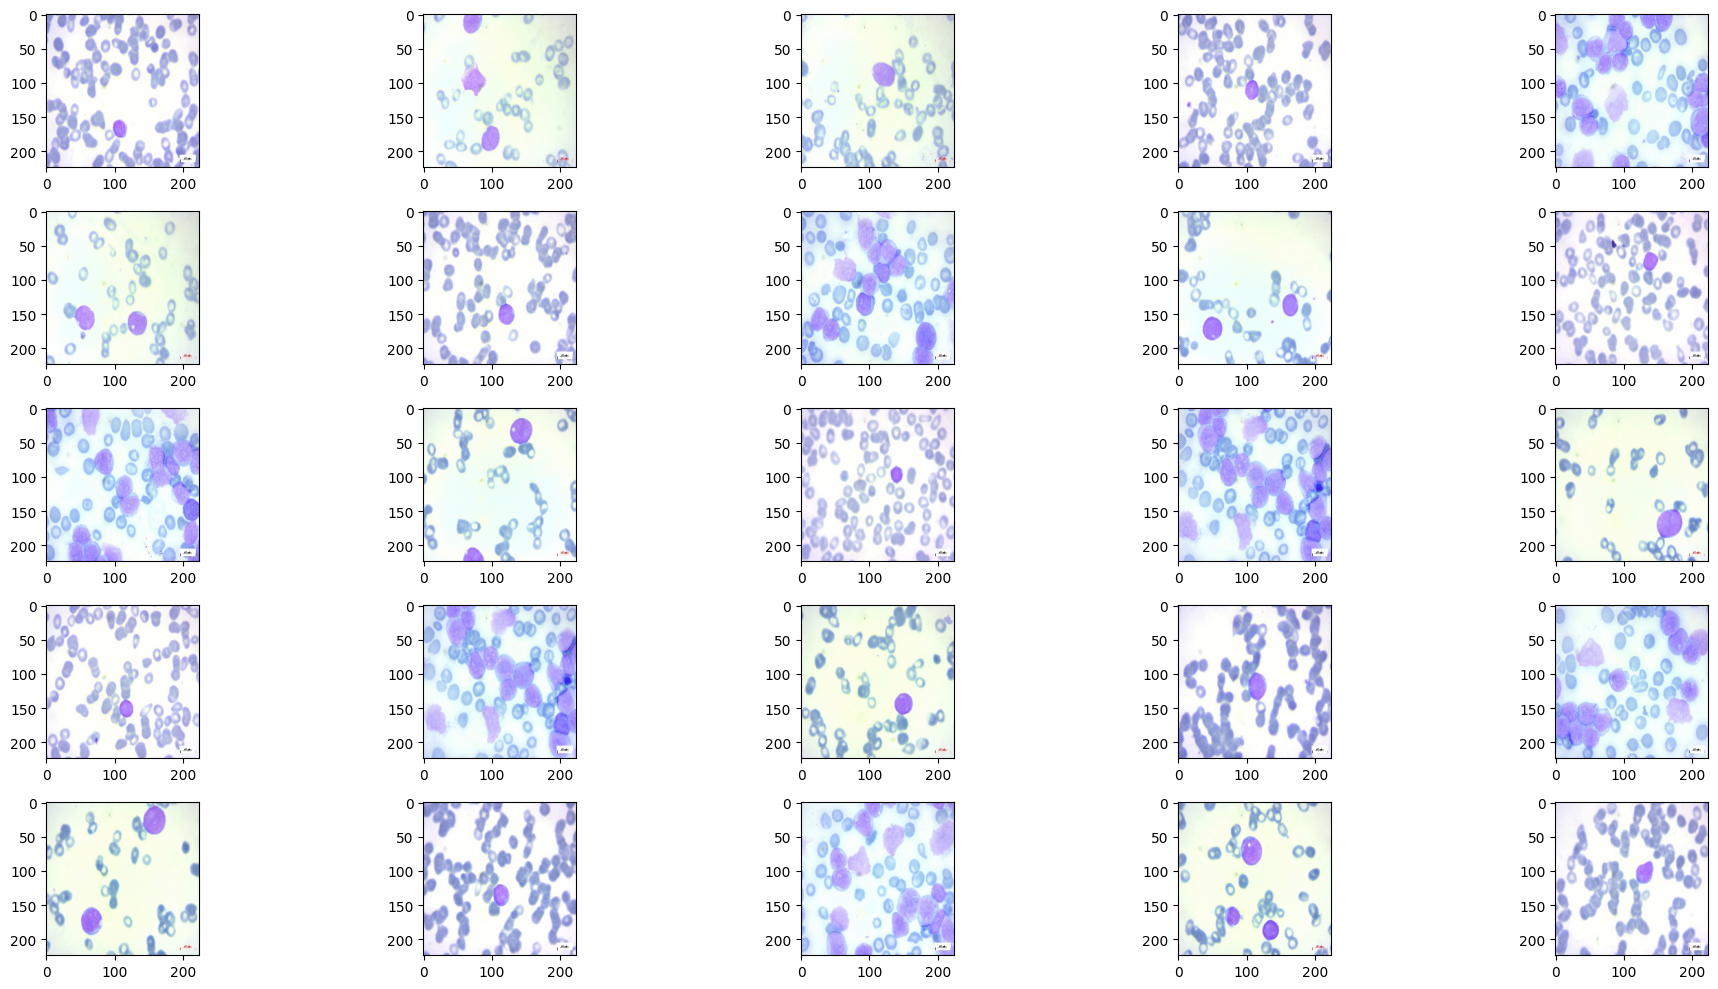

In [13]:
plot_imgs(malignant_pre_B_path,num_imgs=25)

# **malignant-pro-B**

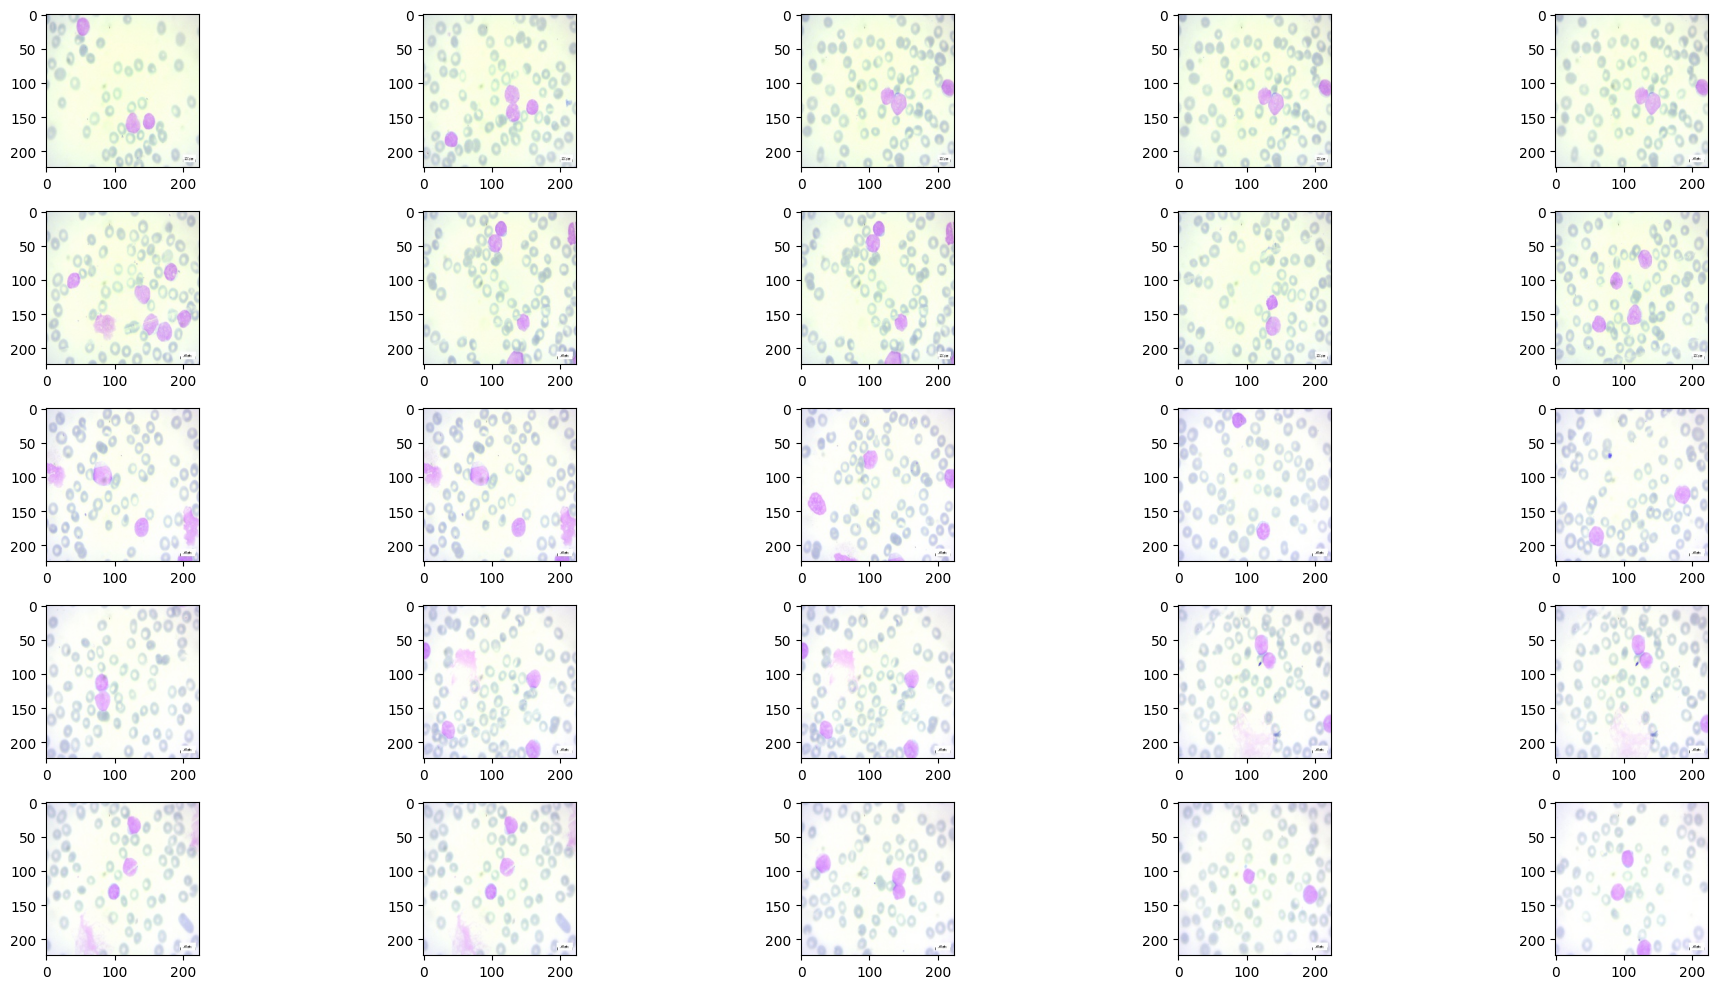

In [14]:
plot_imgs(malignant_pro_B_path,num_imgs=25)

# **malignant-early-pre-B**

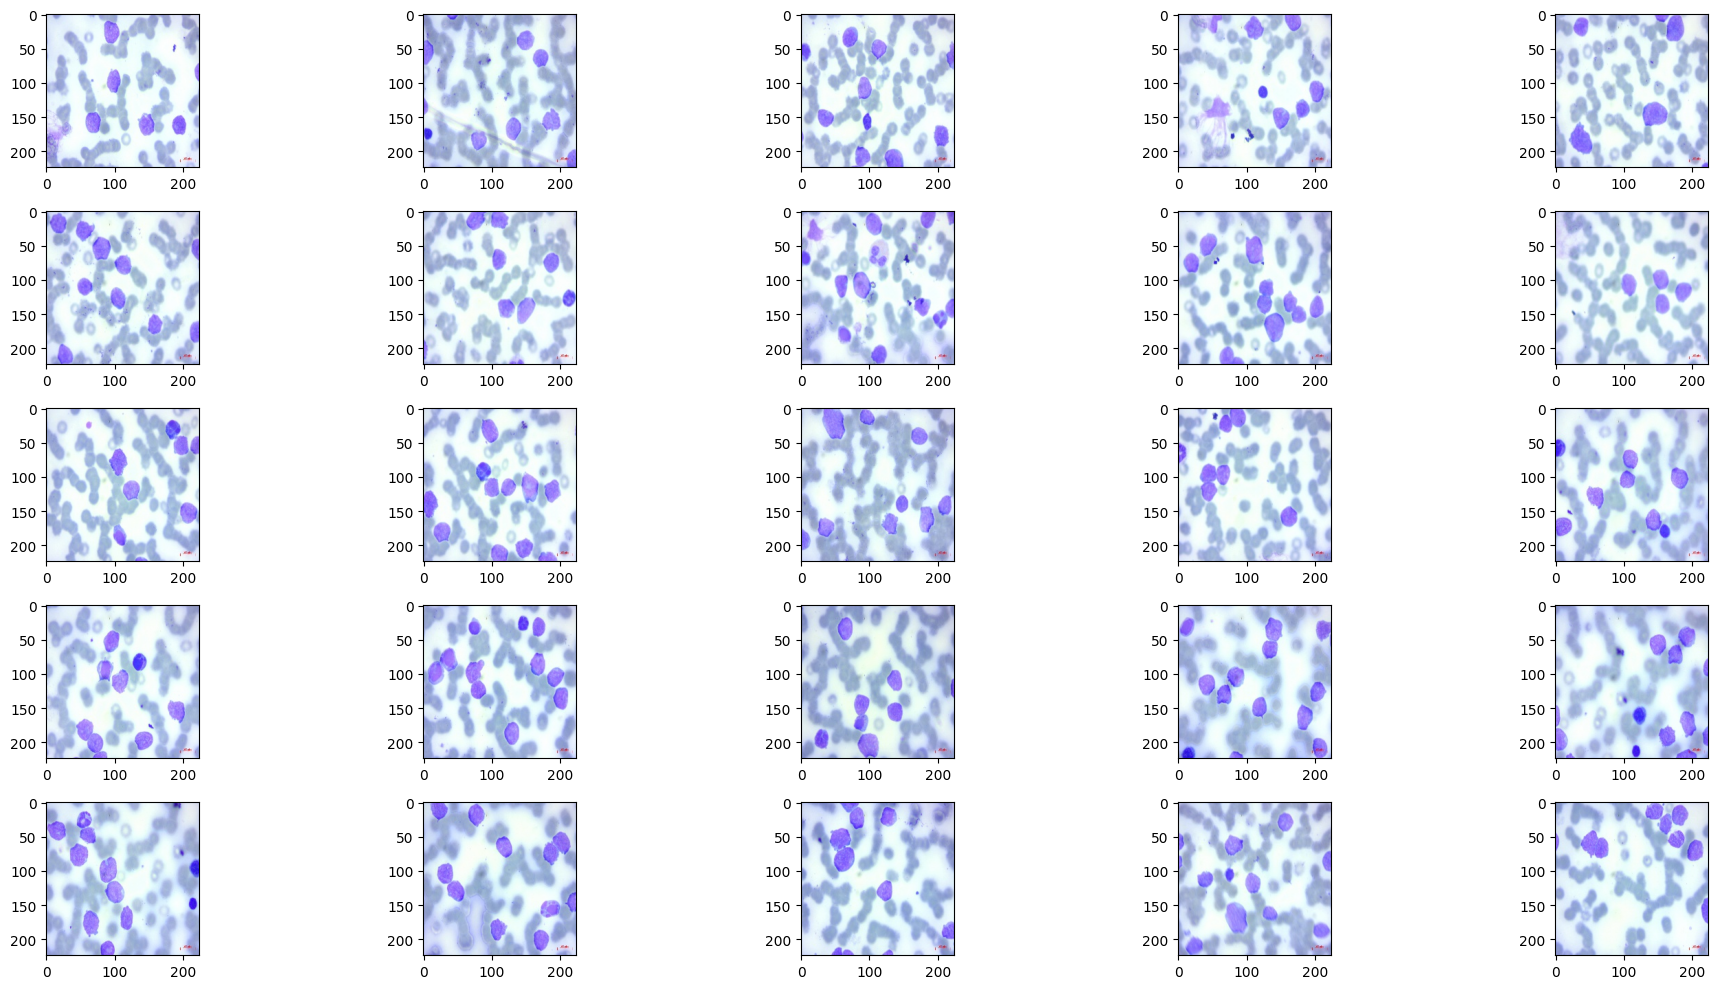

In [23]:
plot_imgs(malignant_early_pre_B_path,num_imgs=25)

# **Make a list of labels and file paths**

In [24]:
Benign_dir = ["Original\Benign"]

Malignant_Pre_B_dirs = ["Original\Pre"]


Malignant_Pro_B_dirs =["Original\Pro"]


Malignant_early_Pre_B_dirs = ["Original\Early"]

filepaths = []
labels = []
dict_lists = [Benign_dir, Malignant_Pre_B_dirs,Malignant_Pro_B_dirs, Malignant_early_Pre_B_dirs]
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                            filepaths  labels
0  Original\Benign\WBC-Benign-001.jpg  Benign
1  Original\Benign\WBC-Benign-002.jpg  Benign
2  Original\Benign\WBC-Benign-003.jpg  Benign
3  Original\Benign\WBC-Benign-004.jpg  Benign
4  Original\Benign\WBC-Benign-005.jpg  Benign
labels
Malignant_early Pre-B    985
Malignant_Pre-B          963
Malignant_Pro-B          804
Benign                   504
Name: count, dtype: int64


# **splitting data**

In [25]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [26]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)

(2604, 2)
(977, 2)
(652, 2)


# **Data Augmentation**

In [27]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)


train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=8,
                                      shuffle=False            
                                     )


test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )


val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 2604 validated image filenames belonging to 4 classes.
Found 977 validated image filenames belonging to 4 classes.
Found 652 validated image filenames belonging to 4 classes.


In [28]:
classes=list(train.class_indices.keys())
print (classes)

['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


# **Show Augmented Images**

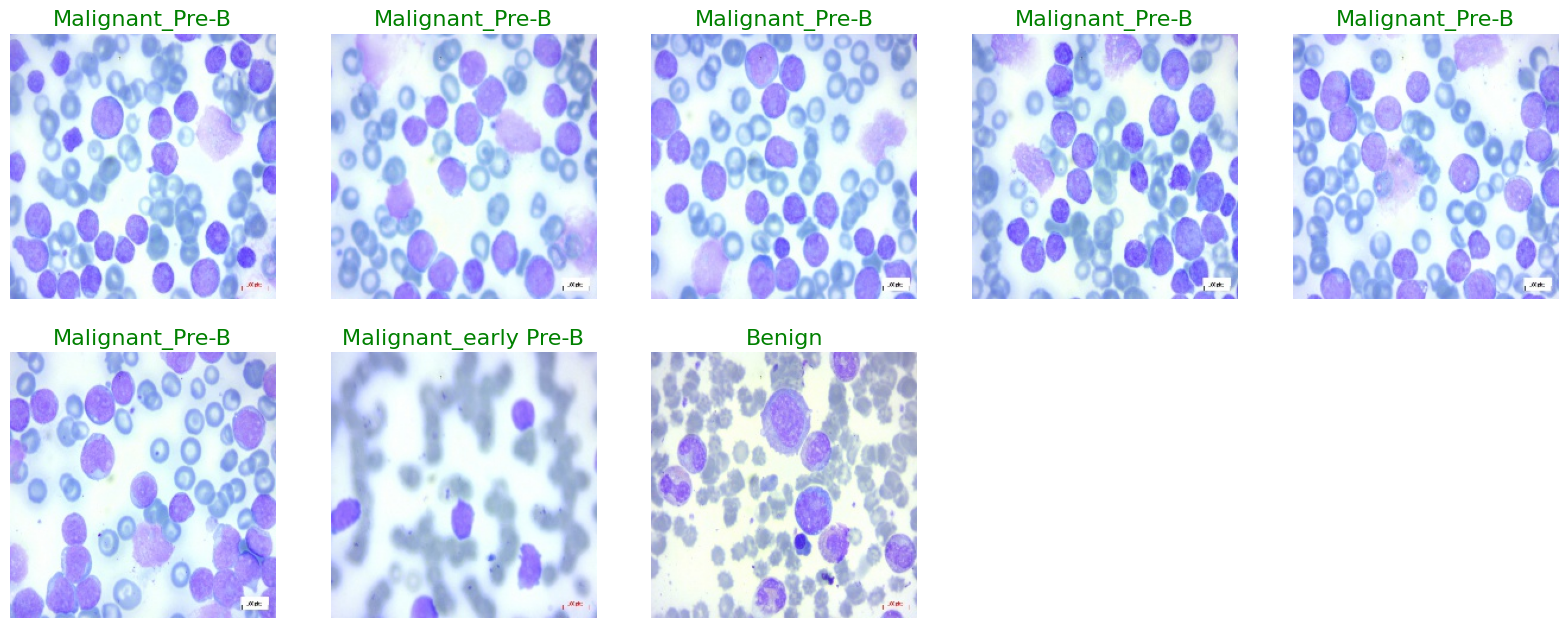

In [29]:
def show_Blood_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Blood_images(train)

# *Using VGG19 Model*

In [30]:
vgg_model=VGG19(weights="imagenet",include_top=False,input_shape=(224,224,3))

model=Sequential()

model.add(vgg_model)

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))


model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(4,activation="softmax"))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [34]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1735s 5s/step - accuracy: 0.5017 - loss: 1.1061 - val_accuracy: 0.8834 - val_loss: 0.2984
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1785s 5s/step - accuracy: 0.8641 - loss: 0.3590 - val_accuracy: 0.9218 - val_loss: 0.2361
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1751s 5s/step - accuracy: 0.9418 - loss: 0.1876 - val_accuracy: 0.9785 - val_loss: 0.1127
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1709s 5s/step - accuracy: 0.9841 - loss: 0.0753 - val_accuracy: 0.9770 - val_loss: 0.0543
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1686s 5s/step - accuracy: 0.9858 - loss: 0.0811 - val_accuracy: 0.9893 - val_loss: 0.0268


In [36]:
model.evaluate(test, verbose=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9914 - loss: 0.0243


[0.021219095215201378, 0.9918116927146912]

In [37]:
model.save("leukemia_vgg16_98.keras")
model.save("leukemia_vgg16_98.h5")

# **plot history**

<Axes: >

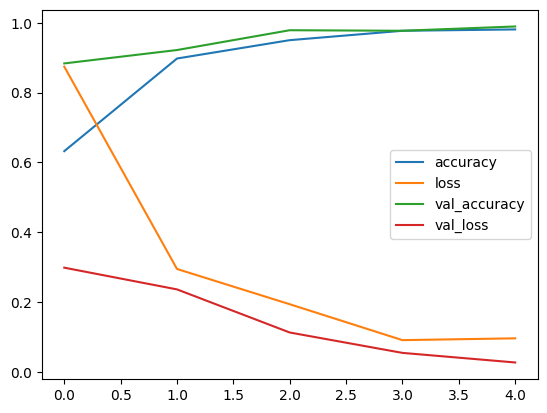

In [38]:
model_loss = pd.DataFrame(history.history)
model_loss.plot()

# **Predict test**

In [39]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

123/123 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step


In [40]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                       precision    recall  f1-score   support

               Benign       0.99      0.98      0.98       171
      Malignant_Pre-B       1.00      0.99      1.00       288
      Malignant_Pro-B       1.00      1.00      1.00       226
Malignant_early Pre-B       0.98      0.99      0.99       292

             accuracy                           0.99       977
            macro avg       0.99      0.99      0.99       977
         weighted avg       0.99      0.99      0.99       977

Accuracy of the Model: 99.2%


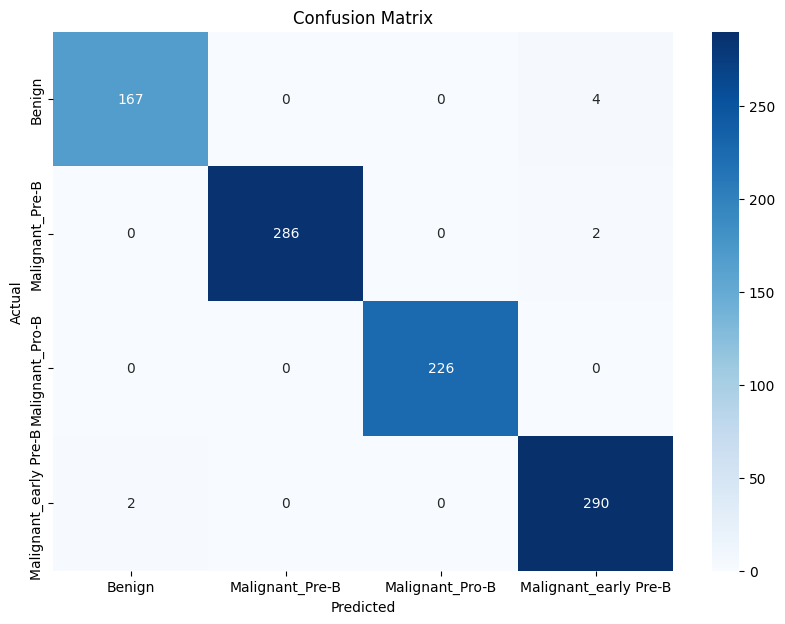

In [41]:
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

# prediction functions

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import datetime
import os
import cv2

In [2]:
# Model loading function with error handling
def load_model(model_path):
    try:
        return tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Error loading model '{model_path}': {e}")
        return None
    
def preprocessing(img, img_shape):
    # Keep as RGB
    img = np.array(img)
    img = cv2.resize(img, img_shape)  # Resize to model's expected input size
#    img = img / norm_fac  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_colon_cancer(image):
    model = load_model('leukemia_model.h5')
    if model is None:
        return "Error: Model could not be loaded"
    
    processed_img = preprocessing(image, (224,224))
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_names = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']
    prediction = class_names[predicted_class]
        
    result = {
        "Prediction": prediction,
        "Analysis Date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Note": "This is an automated analysis and should be verified by a healthcare professional."
    }
    
    return result

In [6]:
img1 = cv2.imread("imags\leukemia_B.jpg")
img2 = cv2.imread("imags\leukemia_pre.jpg")
img3 = cv2.imread("imags\leukemia_pro.jpg")
img4 = cv2.imread("imags\leukemia_E.jpg")

predict_colon_cancer(img4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


{'Prediction': 'Malignant_Pre-B',
 'Analysis Date': '2024-10-24 14:22:05',
 'Note': 'This is an automated analysis and should be verified by a healthcare professional.'}